In [1]:
import os
import glob
import json
import gensim
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

/opt/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
ROOT = os.getcwd().split("src")[0]

In [3]:
# counter, TF-IDF, word2vec, bert
vector_type = "word2vec"

### Required Functions

In [4]:
def write_json_file(data, file):
    '''
    Write data to JSON file
    '''

    with open(f"{file}", "w") as f:
        json.dump(data, f)

In [5]:
def read_json_file(file):
    '''
    Read data from JSON file
    '''

    with open(f"{file}", "r") as f:
        data = json.load(f)
    
    return data

### Import Vectors

In [6]:
industrial_strategy_chapters = read_json_file(f"{ROOT}/data/industrial_strategy/json/vectorised/{vector_type}_vectors.json")
ref_submission_vectors = read_json_file(f"{ROOT}/data/ref_submissions/json/vectorised/{vector_type}_vectors.json")
paper_vectors = read_json_file(f"{ROOT}/data/papers/json/vectorised/{vector_type}_vectors.json")

In [7]:
industrial_strategy_vector = []
num_chapters = 0
for chapter in industrial_strategy_chapters.keys():
    if num_chapters == 0:
        industrial_strategy_vector = industrial_strategy_chapters[chapter]
    else:
        industrial_strategy_vector = np.add(industrial_strategy_vector,
                                            industrial_strategy_chapters[chapter])
    num_chapters += 1
industrial_strategy_vector /= num_chapters
industrial_strategy_vector = np.array([industrial_strategy_vector])

### REF Submissions
#### Cosine Similarity

In [8]:
cosine_similarities = {}
for ref_submission_vector in ref_submission_vectors:
    ref_vector = np.array([ref_submission_vectors[ref_submission_vector]])
    similarity = cosine_similarity(ref_vector, industrial_strategy_vector)
    cosine_similarities[ref_submission_vector] = similarity[0][0]

In [9]:
write_json_file(cosine_similarities,
                f"{ROOT}/output/economic_benefit/{vector_type}_ref_cosine_similarities.json")

In [10]:
histogram_vals = []
pd_dict = {
    "paper": [],
    "similarity": []
}

for paper in cosine_similarities.keys():
    histogram_vals.append(cosine_similarities[paper])
    pd_dict["paper"].append(paper)
    pd_dict["similarity"].append(cosine_similarities[paper])

df = pd.DataFrame(pd_dict)

In [11]:
df

,paper,similarity
0,10007767-22--Public Policy and Public Debate -...,0.966925
1,10003678-32--Impact of philosophy of contempor...,0.900309
2,10007767-3--Disorders of the Menstrual Cycle -...,0.849630
3,10007805-12--Sustainable productivity and grow...,0.962581
4,10007790-26--1. Life After Stroke-Influence of...,0.917969
...,...,...
4574,10007852-1--The use of aspirin as a primary pr...,0.869733
4575,10007775-28-B-Language policy_ informing polic...,0.929803
4576,10001282-16--Transforming the Built Environmen...,0.954618
4577,"10007803-8--Deliverics; Non-viral, non-toxic D...",0.847614


#### Overview of Similarity Scores

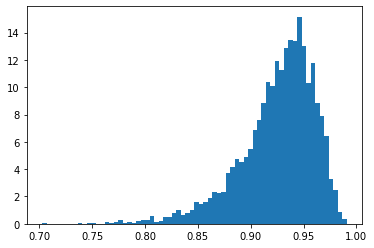

In [12]:
plot = plt.hist(histogram_vals, density=True, bins="sqrt")
plt.show()

### Papers
#### Cosine Similarity

In [8]:
cosine_similarities = {}
for paper_vector in paper_vectors:
    cosine_similarities[paper_vector] = {}
    try:
        vector = np.array([paper_vectors[paper_vector]["tokens"]])
        similarity = cosine_similarity(vector, industrial_strategy_vector)
        cosine_similarities[paper_vector]["similarity"] = similarity[0][0]
        cosine_similarities[paper_vector]["database"] = paper_vectors[paper_vector]["database"]
    except Exception as e:
#         print(f"Error with {paper_vector}: {e}\n\nVector:\n{paper_vectors[paper_vector]}\n")
        pass

In [14]:
write_json_file(cosine_similarities,
                f"{ROOT}/output/economic_benefit/{vector_type}_paper_cosine_similarities.json")

In [9]:
histogram_vals = []
pd_dict = {
    "document_id": [],
    "similarity": [],
    "database": [],
}

for paper in cosine_similarities.keys():
    try:
        histogram_vals.append(cosine_similarities[paper]["similarity"])
        pd_dict["document_id"].append(paper)
        pd_dict["similarity"].append(cosine_similarities[paper]["similarity"])
        pd_dict["database"].append(cosine_similarities[paper]["database"])
    except:
        pass
        
doc_similarity = pd.DataFrame(pd_dict)

In [10]:
len(histogram_vals)

1633

#### Overview of Similarity Scores

In [17]:
doc_similarity.head()

,document_id,similarity,database
0,39771b25b18011eb9a4144af2806d069,0.820393,scopus
1,a0f45476b18011eb983344af2806d069,0.882548,scopus
2,750c1ab4b17f11ebbbcc44af2806d069,0.827250,scopus
3,2ad4a7dcb17e11eb982f44af2806d069,0.872325,scopus
4,6d780905b17f11eb8d2644af2806d069,0.753782,scopus


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


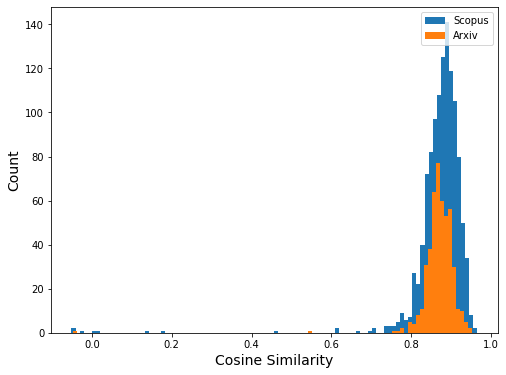

In [11]:
plt.figure(figsize=(8,6))
plt.hist(doc_similarity[doc_similarity["database"] == "scopus"]["similarity"].to_list(), bins=100, label="Scopus")
plt.hist(doc_similarity[doc_similarity["database"] == "arxiv"]["similarity"].to_list(), bins=100, label="Arxiv")
plt.xlabel("Cosine Similarity", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.savefig("overlapping_histograms_with_matplotlib_Python.eps")

#### Import Logs
The logs contain additional information about the papers such as the title and published journal

In [102]:
def load_logs(api):
    temp_dfs = []
    log_dir = f"{ROOT}/src/scraping_papers/logs"
    log_files = glob.glob(f"{log_dir}/{api}/*_success.csv",
                          recursive=True)

    for log_file in log_files:
        try:
            if '.csv' in log_file:
                if api == "arxiv":
                    col_names = [
                        "database",
                        "document_id",
                        "title",
                        "subject_areas",
                        "url"
                    ]
                    temp_df = pd.read_csv(
                        f"{log_file}",
                        sep="\t",
                        header=None,
                        names=col_names,
                    )
                else:
                    col_names = [
                        "database",
                        "document_id",
                        "title",
                        "scopus_id",
                        "doi",
                        "pii",
                        "document_type",
                        "cited_count",
                        "cover_date",
                        "publication_name",
                        "keywords",
                        "subject_areas",
                        "subject_areas_abb",
                    ]
                    temp_df = pd.read_csv(
                        f"{log_file}",
                        header=None,
                        sep="\t",
                        names=col_names,
                    )
                temp_dfs.append(temp_df)
            else:
                continue
        except Exception as e:
            print(f"Error reading {log_file}: {e}")
                
    print(f"Loaded {len(temp_dfs)} log files")
    df = pd.concat(temp_dfs, axis=0, ignore_index=True)
    return df

In [103]:
scopus_paper_logs = load_logs("scopus")
arxiv_paper_logs = load_logs("arxiv")
(scopus_paper_logs.shape, arxiv_paper_logs.shape)

Loaded 6 log files
Loaded 4 log files


((1210, 13), (721, 5))

In [117]:
scopus_paper_logs.head(2)

,database,document_id,title,scopus_id,doi,pii,document_type,cited_count,cover_date,publication_name,keywords,subject_areas,subject_areas_abb
0,Scopus,c148c132b17b11eba19c44af2806d069,updating the models and uncertainty of mechani...,SCOPUS_ID:85104358902,10.1016/j.gsf.2021.101198,None,Article,0,2021-09-01,Geoscience Frontiers,None,[],[]
1,Scopus,c26c3d5ab17b11eba09c44af2806d069,predicting for disease resistance in aquacultu...,SCOPUS_ID:85102360084,10.1016/j.aqrep.2021.100660,None,Article,0,2021-07-01,Aquaculture Reports,None,[],[]


In [105]:
count = 0
scopus_ids = arxiv_paper_logs["document_id"].tolist()
for document_id in cosine_similarities.keys():
    if document_id in scopus_ids:
        count += 1
print(arxiv_paper_logs.shape)
count

(721, 5)


472

In [118]:
arxiv_paper_logs.head(2)

,database,document_id,title,subject_areas,url
0,Arxiv,af456fc0d18b11ea9a8facde48001122,Stochastic Gradient MCMC Methods for Hidden Ma...,stat.ML,http://arxiv.org/abs/1706.04632v1
1,Arxiv,b395da92d18b11ea9a8facde48001122,Learning Non-Convergent Non-Persistent Short-R...,stat.ML,http://arxiv.org/abs/1904.09770v4


In [112]:
logs = pd.concat([arxiv_paper_logs[["document_id", "title", "subject_areas"]].copy("deep"),
                  scopus_paper_logs[["document_id", "title", "subject_areas"]].copy("deep")],
                 ignore_index=True)

In [119]:
logs.head(2)

,document_id,title,subject_areas
0,af456fc0d18b11ea9a8facde48001122,Stochastic Gradient MCMC Methods for Hidden Ma...,stat.ML
1,b395da92d18b11ea9a8facde48001122,Learning Non-Convergent Non-Persistent Short-R...,stat.ML


In [140]:
scopus_overview = pd.merge(scopus_paper_logs, doc_similarity, on="document_id", how="inner")
scopus_overview.head(5)

,database_x,document_id,title,scopus_id,doi,pii,document_type,cited_count,cover_date,publication_name,keywords,subject_areas,subject_areas_abb,similarity,database_y
0,Scopus,c148c132b17b11eba19c44af2806d069,updating the models and uncertainty of mechani...,SCOPUS_ID:85104358902,10.1016/j.gsf.2021.101198,None,Article,0,2021-09-01,Geoscience Frontiers,None,[],[],0.879991,scopus
1,Scopus,c26c3d5ab17b11eba09c44af2806d069,predicting for disease resistance in aquacultu...,SCOPUS_ID:85102360084,10.1016/j.aqrep.2021.100660,None,Article,0,2021-07-01,Aquaculture Reports,None,[],[],0.911047,scopus
2,Scopus,c4b6818fb17b11eba7b144af2806d069,cu msdspa flexible parallelized reversible jum...,SCOPUS_ID:85100997951,10.1016/j.softx.2021.100664,None,Article,0,2021-06-01,SoftwareX,None,[],[],0.906541,scopus
3,Scopus,c5f886dfb17b11eba47e44af2806d069,modelling the early phase of the belgian covid...,SCOPUS_ID:85103386931,10.1016/j.epidem.2021.100449,None,Article,0,2021-06-01,Epidemics,None,[],[],0.916308,scopus
4,Scopus,c6e946b2b17b11ebb3b444af2806d069,illustration of missing data handling techniqu...,SCOPUS_ID:85103775939,10.1016/j.jksus.2021.101403,None,Review,0,2021-06-01,Journal of King Saud University - Science,None,[],[],0.864101,scopus


In [138]:
arxiv_overview = pd.merge(arxiv_paper_logs, doc_similarity, on="document_id", how="inner")
arxiv_overview.head(5)

,database_x,document_id,title,subject_areas,url,similarity,database_y
0,Arxiv,af456fc0d18b11ea9a8facde48001122,Stochastic Gradient MCMC Methods for Hidden Ma...,stat.ML,http://arxiv.org/abs/1706.04632v1,0.847002,arxiv
1,Arxiv,b395da92d18b11ea9a8facde48001122,Learning Non-Convergent Non-Persistent Short-R...,stat.ML,http://arxiv.org/abs/1904.09770v4,0.868339,arxiv
2,Arxiv,b96c1508d18b11ea9a8facde48001122,Automating Involutive MCMC using Probabilistic...,stat.CO,http://arxiv.org/abs/2007.09871v2,0.849428,arxiv
3,Arxiv,bc5cf8d6d18b11ea9a8facde48001122,Subsampling MCMC - An introduction for the sur...,stat.ME,http://arxiv.org/abs/1807.08409v4,0.862881,arxiv
4,Arxiv,bf2c59f8d18b11ea9a8facde48001122,Quantifying MCMC Exploration of Phylogenetic T...,q-bio.PE,http://arxiv.org/abs/1405.2120v2,0.877656,arxiv


#### Arxiv Analysis
##### Subject Areas

In [129]:
arxiv_group = arxiv_overview.groupby("subject_areas").mean().reset_index()
arxiv_group = arxiv_group.sort_values(by="similarity", ascending=False)
arxiv_group

,subject_areas,similarity
17,cs.DM,0.926733
29,cs.SE,0.919392
25,cs.NI,0.911645
1,astro-ph.GA,0.911344
22,cs.MS,0.910822
30,cs.SY,0.908984
16,cs.DC,0.906256
58,stat.OT,0.905152
24,cs.NE,0.903106
46,physics.chem-ph,0.897788


In [132]:
arxiv_group.describe()

,similarity
count,59.000000
mean,0.867406
std,0.051863
min,0.543797
25%,0.857436
50%,0.873782
75%,0.894504
max,0.926733


<BarContainer object of 59 artists>

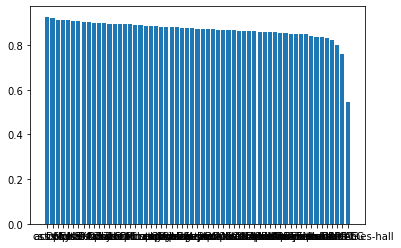

In [131]:
plt.bar(arxiv_group["subject_areas"].to_list(),
        arxiv_group["similarity"].to_list())

#### Scopus
##### Subject Area

##### Publication Venue

In [154]:
scopus_publication_group = scopus_overview.groupby("publication_name").mean().reset_index()
scopus_publication_group = scopus_publication_group.sort_values(by="similarity", ascending=False)
scopus_publication_group

,publication_name,cited_count,similarity
63,Energy Policy,1.000000,0.954267
221,The Lancet,54.000000,0.949864
48,Data and Knowledge Engineering,32.000000,0.948513
210,Social Science and Medicine,6.000000,0.944514
110,Journal of Cleaner Production,5.000000,0.943827
...,...,...,...
29,Cell Systems,8.000000,0.779560
148,Journal of the American Society for Mass Spect...,16.000000,0.777230
45,Contaduria y Administracion,0.000000,0.011216
207,Revista Internacional de Metodos Numericos par...,4.333333,-0.023352


In [153]:
scopus_publication_group.describe()

,cited_count,similarity
count,237.000000,237.000000
mean,18.650904,0.870735
std,29.796700,0.105090
min,0.000000,-0.045687
25%,2.000000,0.863887
50%,8.500000,0.883854
75%,24.166667,0.899812
max,241.333333,0.954267


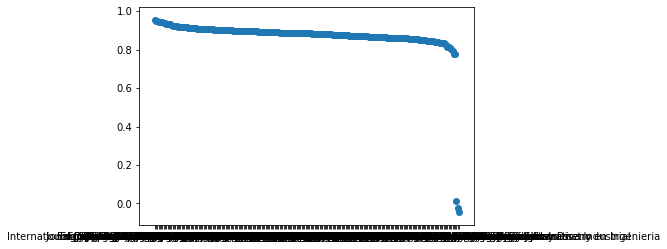

In [155]:
plt.scatter(scopus_publication_group["publication_name"].to_list(),
            scopus_publication_group["similarity"].to_list())

##### Citations

In [143]:
scopus_citation_group = scopus_overview.groupby("cited_count").mean().reset_index()
scopus_citation_group = scopus_citation_group.sort_values(by="similarity", ascending=False)
scopus_citation_group

,cited_count,similarity
62,62,0.942145
99,115,0.931683
78,79,0.926432
89,96,0.923409
106,135,0.918059
...,...,...
109,164,0.805570
66,66,0.792989
68,68,0.787762
88,95,0.763762


In [157]:
scopus_citation_group.describe()

,cited_count,similarity
count,138.000000,138.000000
mean,138.485507,0.867423
std,219.208904,0.030009
min,0.000000,0.733180
25%,34.250000,0.855445
50%,68.500000,0.868975
75%,126.500000,0.885737
max,1572.000000,0.942145


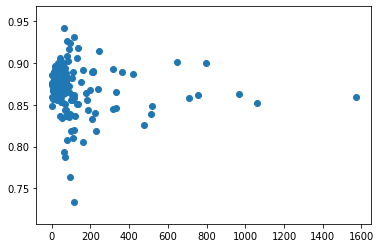

In [156]:
plt.scatter(scopus_citation_group["cited_count"].to_list(),
            scopus_citation_group["similarity"].to_list())